In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dataset_path = 'Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [5]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [7]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Chuyển đổi sang tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out


input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

In [10]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
def r_squared(y_true, y_pred):
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [12]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_preds.append(outputs)
        train_targets.append(y_batch)

    train_loss /= len(train_loader.dataset)
    train_preds = torch.cat(train_preds, dim=0)
    train_targets = torch.cat(train_targets, dim=0)
    train_r2_score = r_squared(train_targets, train_preds)
    train_losses.append(train_loss)
    train_r2.append(train_r2_score)

    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_preds.append(outputs)
            val_targets.append(y_batch)

    val_loss /= len(val_loader.dataset)
    val_preds = torch.cat(val_preds, dim=0)
    val_targets = torch.cat(val_targets, dim=0)
    val_r2_score = r_squared(val_targets, val_preds)
    val_losses.append(val_loss)
    val_r2.append(val_r2_score)

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train R²: {train_r2_score:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val R²: {val_r2_score:.4f}')

Epoch 1/100, Train Loss: 406.1927, Train R²: -6.0789, Val Loss: 247.3821, Val R²: -2.2047
Epoch 2/100, Train Loss: 190.7129, Train R²: -2.3237, Val Loss: 67.3669, Val R²: 0.1273
Epoch 3/100, Train Loss: 53.3199, Train R²: 0.0708, Val Loss: 16.7370, Val R²: 0.7832
Epoch 4/100, Train Loss: 10.0685, Train R²: 0.8245, Val Loss: 50.5381, Val R²: 0.3453
Epoch 5/100, Train Loss: 69.1862, Train R²: -0.2057, Val Loss: 23.4543, Val R²: 0.6962
Epoch 6/100, Train Loss: 13.4704, Train R²: 0.7652, Val Loss: 13.2270, Val R²: 0.8286
Epoch 7/100, Train Loss: 22.0397, Train R²: 0.6159, Val Loss: 23.8653, Val R²: 0.6908
Epoch 8/100, Train Loss: 10.6329, Train R²: 0.8147, Val Loss: 18.7861, Val R²: 0.7566
Epoch 9/100, Train Loss: 11.5201, Train R²: 0.7992, Val Loss: 12.4328, Val R²: 0.8389
Epoch 10/100, Train Loss: 7.3152, Train R²: 0.8725, Val Loss: 24.9095, Val R²: 0.6773
Epoch 11/100, Train Loss: 23.4522, Train R²: 0.5913, Val Loss: 18.6156, Val R²: 0.7588
Epoch 12/100, Train Loss: 9.1962, Train R²: 0.

In [13]:
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test).item()
    test_r2 = r_squared(y_test, y_pred)
    print('\nEvaluation on test set:')
    print(f'Test Loss: {test_loss:.4f}, Test R²: {test_r2:.4f}')


Evaluation on test set:
Test Loss: 10.9121, Test R²: 0.8057


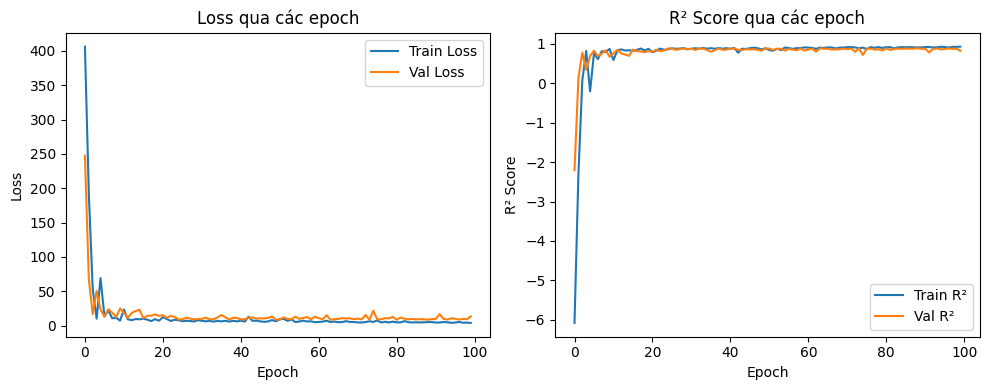

In [14]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss qua các epoch')
plt.legend()

# Vẽ biểu đồ R²
plt.subplot(1, 2, 2)
plt.plot(train_r2, label='Train R²')
plt.plot(val_r2, label='Val R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Score qua các epoch')
plt.legend()
plt.tight_layout()
plt.show()